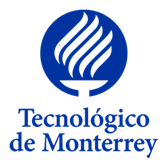

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 3

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Cargando Conjunto de Datos**

In [2]:
# Importando librerias requeridas
import re
import json
import uuid
import logging
import pyarrow.parquet as pq
import pandas as pd
import numpy as np


from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_aws import BedrockLLM


In [3]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='../Avance3_Equipo37_Select_Data_Job.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
DATA_SET = '../hotel-clean-data-set/parquet4p'


In [5]:
# Cargando conjunto de datos de hoteles como un Dataset multi-parte de Apache Parquet
dataset = pq.ParquetDataset(DATA_SET)
table = dataset.read()

In [6]:
# Creando un Dataframe de Pandas para el analisis
dataframe = table.to_pandas()


In [7]:
# Corroboramos el tamaño de nuestro DataFrame para tenerlo como referencia.
logger.info(f'Datos cargados y convertidos a un dataframe con dimensiones {dataframe.shape}')

## **Generación de Archivos de Datos para AWS Bedrock**


In [8]:
dataframe = dataframe.groupby('CountryCode').sample(frac=0.00697, random_state=42)

In [9]:
dataframe.shape

(1000, 11)

In [10]:
dataframe.head()

,HotelCode,HotelName,Description,Address,Pincode,CountryCode,PhoneNumber,CityName,Longitude,Latitude,HotelRating
978225,1029635,grau roig andorra boutique hotel & spa,HeadLine : Near Grau Roig Ski ResortLocation :...,estacion de esqui grandvalira sector grau roig...,AD200,AD,+376755556,Grau Roig,1.700980,42.532760,5.0
498943,1497248,"lapita, dubai parks and resorts, autograph col...",HeadLine : Near MOTIONGATE™ DubaiLocation : Lo...,"sheikh zayed road, dubai parks & resortsp.o. b...",,AE,971-4-8109999,Dubai,55.003544,24.916164,4.0
362889,6176857,riu dubai,HeadLine : Near Souk Al MarfaLocation : When y...,"deira islands, , dubai, 17777, united arab emi...",17777,AE,34-97-1524938056,Dubai,55.306667,25.300407,4.0
694788,1100809,abidos hotel apartment dubailand,HeadLine : Near Zayed UniversityLocation : Wit...,"dubailand residence area, p.o. box 232808dubai...",232808,AE,971-4-4378500,Dubai,55.379510,25.089160,4.0
977131,5000526,sofitel dubai the obelisk,"Situated in Dubai, 3 km from Dubai World Trade...","sheikh rashid road wafi p.o. box 30904, bur du...",30904,AE,+971 4 324 9999,Dubai,55.318615,25.231130,5.0


In [11]:
model_kwargs_premier = {'temperature': 0, 'top_p': 0.7, 'top_k': 50, 'max_tokens': 3000}
llm = BedrockLLM(model_id='mistral.mistral-7b-instruct-v0:2', model_kwargs=model_kwargs_premier)

In [70]:
template = '''
You are a helpful travel assistant.
Your task is to write a one factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::
'''

generation_prompt = PromptTemplate.from_template(template)

generation_chain = generation_prompt | llm | StrOutputParser()

In [71]:
groundedness_critique_template = '''
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: '''

relevance_critique_template = '''
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to travel assistants helping people to make their travel arrangements.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here is the question.

Question: {question}\n
Answer::: '''

standalone_critique_template = '''
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that this question only makes sense in a specific context, and 5 means that this question makes sense by itself.
Your answer is for this question only.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here is the question.

Question: {question}\n
Answer::: '''

groundedness_critique_prompt = PromptTemplate.from_template(
    groundedness_critique_template
)
groundedness_critique_agent = groundedness_critique_prompt | llm

relevance_critique_prompt = PromptTemplate.from_template(
    relevance_critique_template
)
relevance_critique_agent = relevance_critique_prompt | llm

standalone_critique_prompt = PromptTemplate.from_template(
    standalone_critique_template
)
standalone_critique_agent = standalone_critique_prompt | llm

In [58]:
hotel_desc = \
    dataframe.iloc[0]['HotelName'].title() + \
    'is located in ' + \
    dataframe.iloc[0]['CityName'] + '. ' + \
    dataframe.iloc[0]['Description']


response = generation_chain.invoke({'context': hotel_desc})
print(response)

Factoid question: How far is Grau Roig Andorra Boutique Hotel & Spa from Grau Roig Ski Resort?
Answer: Grau Roig Andorra Boutique Hotel & Spa is steps away from Grau Roig Ski Resort.


In [59]:
question = response.split("Factoid question: ")[1].split("Answer: ")[0].strip()
answer = response.split("Answer: ")[1].strip()
print(question, answer)

How far is Grau Roig Andorra Boutique Hotel & Spa from Grau Roig Ski Resort? Grau Roig Andorra Boutique Hotel & Spa is steps away from Grau Roig Ski Resort.


In [60]:
groundedness_evaluation = groundedness_critique_agent.invoke(
    {"context": hotel_desc, "question": question}
)
relevance_evaluation = relevance_critique_agent.invoke(
    {"question": question}
)

groundedness_score = int(groundedness_evaluation.split('Total rating: ')[1][0].strip())
groundedness_eval = groundedness_evaluation.split('Total rating: ')[0].split(
    'Evaluation: '
)[1].strip()
relevance_score = int(relevance_evaluation.split('Total rating: ')[1][0].strip())
relevance_eval = relevance_evaluation.split('Total rating: ')[0].split(
    'Evaluation: '
)[1].strip()


In [61]:
groundedness_evaluation

'\nEvaluation: The context clearly states that Grau Roig Andorra Boutique Hotel & Spa is located in Grau Roig and is near Grau Roig Ski Resort. Therefore, the question is answerable with the context.\n\nTotal rating: 5\n\nNote: The context does not provide an exact distance to Grau Roig Ski Resort, but since the question asks for the general location and not an exact distance, the context is sufficient to answer the question.'

In [62]:
relevance_evaluation

'\nEvaluation: This question is extremely useful for travel assistants as it provides important information for individuals planning a ski trip to Grau Roig, Andorra. Knowing the distance between the hotel and the ski resort is crucial for determining transportation needs and travel time.\n\nTotal rating: 5.'

In [63]:
groundedness_score = int(groundedness_evaluation.split('Total rating: ')[1][0].strip())
groundedness_eval = groundedness_evaluation.split('Total rating: ')[0].split(
    'Evaluation: '
)[1].strip()
relevance_score = int(relevance_evaluation.split('Total rating: ')[1][0].strip())
relevance_eval = relevance_evaluation.split('Total rating: ')[0].split(
    'Evaluation: '
)[1].strip()

print(groundedness_score, groundedness_eval)
print(relevance_score, relevance_eval)

5 The context clearly states that Grau Roig Andorra Boutique Hotel & Spa is located in Grau Roig and is near Grau Roig Ski Resort. Therefore, the question is answerable with the context.
5 This question is extremely useful for travel assistants as it provides important information for individuals planning a ski trip to Grau Roig, Andorra. Knowing the distance between the hotel and the ski resort is crucial for determining transportation needs and travel time.


In [64]:
# Cargando archivo con los códigos de país y sus nombres. Se van a remover las columnas de códigos alfabético
# de 3 caracteres y numérico por que no se necesitan para preparar el texto extendido de la descripción 
ccdf_full = pd.read_csv('../country-code.csv')
ccdf_full.loc[ccdf_full.isna().any(axis=1),'Alpha2'] = 'NA'
ccdf = ccdf_full.drop(['Alpha3','UNCode'],axis=1)
# Usando el código alfabético del país como índice y creando un diccionario con el conjunto de datos
ccdf = ccdf.set_index('Alpha2')
ccdict = ccdf.to_dict('index')


In [72]:
subi = 0
dataframe_synthetic = pd.DataFrame(
    columns=[
        'question',
        'answer',
        'groundedness_score',
        'groundedness_eval',
        'relevance_score',
        'relevance_eval']
)
# Generando dos archivos por cada registro en el conjunto de datos
for row in dataframe.itertuples():
    # Usando el nombre completo del país si código del país del registro existe en el
    # diccionario de códigos y nombres 
    long_country_name = ''
    if row.CountryCode in ccdict and ccdict[row.CountryCode]['Country'] is not None:
        long_country_name = ccdict[row.CountryCode]['Country']

    hotel_desc = \
        row.HotelName.title() + \
        'is located in ' + \
        row.CityName + ', ' + long_country_name +'. ' + \
        row.Description
    
    # Generando pregunta y respuesta sintética
    response = generation_chain.invoke({'context': hotel_desc})    
    question = response.split("Factoid question: ")[1].split("Answer: ")[0].strip()
    answer = response.split("Answer: ")[1].strip()
    
    # Generando criticas
    groundedness_evaluation = groundedness_critique_agent.invoke(
        {"context": hotel_desc, "question": question}
    )
    relevance_evaluation = relevance_critique_agent.invoke(
        {"question": question}
    )

    groundedness_score = int(groundedness_evaluation.split('Total rating: ')[1][0].strip())
    groundedness_eval = groundedness_evaluation.split('Total rating: ')[0].split(
        'Evaluation: '
    )[1].strip()
    relevance_score = int(relevance_evaluation.split('Total rating: ')[1][0].strip())
    relevance_eval = relevance_evaluation.split('Total rating: ')[0].split(
        'Evaluation: '
    )[1].strip()    
    
    dataframe_synthetic = pd.concat(
        [
            dataframe_synthetic,
            pd.DataFrame(
                [{
                    'question': question,
                    'answer': answer,
                    'groundedness_score': groundedness_score,
                    'groundedness_eval': groundedness_eval,
                    'relevance_score': relevance_score,
                    'relevance_eval': relevance_eval
                }]
            )
        ],
        ignore_index=True
    )
    # Imprimiendo cuenta de registros procesados
    # El ciclo termina una vez procesados 1000 registros
    subi += 1
    if subi > 4:
        break


In [73]:
dataframe_synthetic.head()

,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval
0,How far is Grau Roig Andorra Boutique Hotel & ...,Grau Roig Andorra Boutique Hotel & Spa is step...,5,The context clearly states that Grau Roig Ando...,5,This question is extremely useful for travel a...
1,"How far is Lapita, Dubai Parks And Resorts, Au...","Lapita, Dubai Parks and Resorts, Autograph Col...",5,The question is clearly and unambiguously answ...,5,This question is extremely useful for travel a...
2,What is the distance of Riu Dubai Beach Resort...,The Riu Dubai Beach Resort is 17.6 km (10.9 mi...,5,The context provides the distance of Riu Dubai...,5,This question is useful because it provides sp...
3,What university is within a 10-minute drive fr...,Zayed University,5,The context directly answers the question by s...,5,This question is useful for travel assistants ...
4,What is the name of the hotel located 3 km fro...,Sofitel Dubai The Obelisk,5,The question is clearly and unambiguously answ...,5,This question is quite specific and provides e...


In [74]:
dataframe_synthetic.to_csv('../synthetic.csv')

## **Conclusiones**



‌El objetivo de la base de conocimiento en *Retrieval Augmented Generation*, o *RAG*, es proveer una fuente de información para proveer contexto adicional al modelo generativo, o *LLM* para que pueda generar una mejor respuesta. La calidad de la respuesta dependerá del modelo LLM usado y de la calidad del contenido en la base de conocimiento.

En AWS Bedrock una base de conocimiento se construye usando archivos de texto conteniendo la información de contexto y sus respectivos archivos de metadatos asociados (AWS, s.f.).

Para este proyecto ya se contaba con una base de datos de hoteles que contiene una descripción del hotel que puede incluir amenidades del hotel, guías para check-in y check-out, y/o una lista de atracciones y sitios de interés cercanos. La base de datos también incluye otra información del hotel como el nombre del hotel, la ciudad y el país donde se localiza y el nivel de estrellas.

Crear el archivo con la descripción del hotel con su archivo asociado con metadatos es por lo tanto la única actividad de la etapa de ingeniería de características. 


## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* Aksitov, R., Miryoosefi, S., Li, Z., Li, D., Babayan, S., Kopparapu, K., Fisher, Z., Guo, R., Prakash, S., Srinivasan, P., Zaheer, M., Yu, F., & Kumar, S. (2023). ReST meets ReAct: Self-Improvement for Multi-Step Reasoning LLM Agent. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2312.10003

* 
